In [1]:
import torch
import time
import math
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
 

In [2]:
def generate_disc_set(nb):
    data = torch.empty((nb, 2)).uniform_(-1, 1)
    radius = torch.pow(data, 2).sum(axis=1)
    labels = (radius < 2./math.pi).long()
    return data, labels



In [3]:
def train_model(model, train_input, train_target, mini_batch_size,
                eta = 1e-1, nb_epochs = 100, criterion=torch.nn.CrossEntropyLoss(),
                verbose=True):
    optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    for e in range(nb_epochs):
        acc_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if verbose: print(e, acc_loss)

def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    with torch.no_grad():
        for b in range(0, input.size(0), mini_batch_size):
            prediction = model(input.narrow(0, b, mini_batch_size))
            predicted_class = torch.argmax(prediction, axis=1)
            
            #target_class = torch.argmax(target.narrow(0, b, mini_batch_size), axis=1)
            target_class=target.narrow(0, b, mini_batch_size)
            accuracy = (predicted_class == target_class)
            nb_errors += (~accuracy).int().sum().item()
    error_fraction = nb_errors / target.shape[0]
    return nb_errors, error_fraction

def one_hot_encode(labels):
    target = torch.zeros((labels.shape[0], torch.max(labels) + 1))
    target[~labels.bool(), 0] = 1
    target[labels.bool(), 1] = 1
    return target

def set_init_weights(module, std=0):
    if std == 0: return
    if type(module) == torch.nn.Linear:
        torch.nn.init.normal_(module.weight, mean=0, std=std)
        torch.nn.init.normal_(module.bias, mean=0, std=std)

Number in: 490, Number out: 510


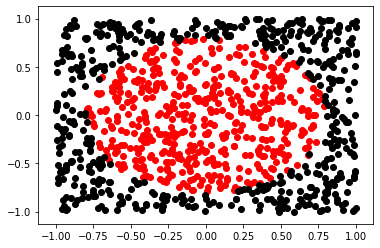

In [4]:
n_samples = 1000
train_data, train_labels = generate_disc_set(n_samples)
test_data, test_labels = generate_disc_set(n_samples)
plt.scatter(train_data[train_labels.bool(),0], train_data[train_labels.bool(),1], c='r')
plt.scatter(train_data[~train_labels.bool(),0], train_data[~train_labels.bool(),1], c='k')
print(f"Number in: {train_labels.sum()}, Number out: {n_samples - train_labels.sum()}")


In [5]:
train_data_std = ((train_data - train_data.mean(axis=0)) / train_data.std(axis=0)).to(device)
train_one_hot_labels = one_hot_encode(train_labels).to(device)
train_labels = train_labels.to(device)

test_data_std = ((test_data - test_data.mean(axis=0)) / test_data.std(axis=0)).to(device)
test_one_hot_labels = one_hot_encode(test_labels).to(device)
test_labels = test_labels.to(device)


In [10]:
def create_shallow_model():
    return torch.nn.Sequential(torch.nn.Linear(2, 128),
                                torch.nn.ReLU(),
                                torch.nn.Linear(128, 2)
                                )

def create_deep_model():
    return torch.nn.Sequential(torch.nn.Linear(2, 4),
                                torch.nn.ReLU(),
                                torch.nn.Linear(4, 8),
                                torch.nn.ReLU(),
                                torch.nn.Linear(8, 16),
                                torch.nn.ReLU(),
                                torch.nn.Linear(16, 32),
                                torch.nn.ReLU(),
                                torch.nn.Linear(32, 64),
                                torch.nn.ReLU(),
                                torch.nn.Linear(64, 128),
                                torch.nn.ReLU(),
                                torch.nn.Linear(128, 2)
                                )

# I can reproduce the results in the solution by using ReLU activation but not Sigmoid as I had defaulted to
                                

In [11]:
for std in [0, 1e-3, 1e-2, 1e-1, 1]:
    shallow_model = create_shallow_model().to(device)
    print(f"==> Initialization std: {std}")
    shallow_model.apply(lambda m: set_init_weights(m, std))
    deep_model = create_deep_model().to(device)
    deep_model.apply(lambda m: set_init_weights(m, std))
    start_time = time.time()
    mini_batch_size = 100
    train_model(shallow_model, train_data_std, train_labels, mini_batch_size,
                    eta = 1e-1, nb_epochs = 250, criterion=torch.nn.CrossEntropyLoss().to(device),
                    verbose=False)
    print(f"Shallow model training time {time.time() - start_time} s")
    nb_errors, error_fraction = compute_nb_errors(shallow_model, test_data_std, test_labels, mini_batch_size)
    print(f"Shallow model error fraction {error_fraction}")
    start_time = time.time()
    train_model(deep_model, train_data_std, train_labels, mini_batch_size,
                    eta = 1e-1, nb_epochs = 250, criterion=torch.nn.CrossEntropyLoss().to(device),
                    verbose=False)
    print(f"Deep model training time {time.time() - start_time} s")
    nb_errors, error_fraction = compute_nb_errors(deep_model, test_data_std, test_labels, mini_batch_size)
    print(f"Deep model error fraction {error_fraction}")

==> Initialization std: 0
Shallow model training time 1.468980312347412 s
Shallow model error fraction 0.029
Deep model training time 3.4992852210998535 s
Deep model error fraction 0.044
==> Initialization std: 0.001
Shallow model training time 1.3297276496887207 s
Shallow model error fraction 0.036
Deep model training time 3.4028255939483643 s
Deep model error fraction 0.521
==> Initialization std: 0.01
Shallow model training time 1.3505349159240723 s
Shallow model error fraction 0.038
Deep model training time 3.409029483795166 s
Deep model error fraction 0.521
==> Initialization std: 0.1
Shallow model training time 1.5973701477050781 s
Shallow model error fraction 0.038
Deep model training time 4.202948093414307 s
Deep model error fraction 0.521
==> Initialization std: 1
Shallow model training time 1.401796579360962 s
Shallow model error fraction 0.023
Deep model training time 3.665940999984741 s
Deep model error fraction 0.521
